In [243]:

import bs4
from bs4 import BeautifulSoup as bs

import requests
import pandas as pd
import numpy as np
import time
import pickle
import statsmodels.api as sm
import seaborn as sns

In [458]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
url="https://www.basketball-reference.com/teams/"
page = requests.get(url).text
soup = bs(page)

In [101]:
# find active franchises
franchises = soup.findAll("th",attrs={"data-stat":"franch_name", "scope":"row"})


In [102]:
# franchise names
franchise_text = [f.getText() for f in franchises]

# link to team pages
franchise_link = [f.find("a") for f in franchises]
franchise_link = [f["href"] for f in franchise_link]
url_base = "https://www.basketball-reference.com"
url_list_teams = [url_base+team for team in franchise_link]

In [ ]:
# list of links for each team for each season
url_list_season=[]
for i in range(2015,2020):
    for h in url_list_teams:
        url_list_season.append(h+str(i)+"_games.html")

In [107]:
page = requests.get(url_list_season[0]).text
soup = bs(page)

full_list_of_links = []

In [108]:
for url in url_list_season:
    page = requests.get(url).text
    soup = bs(page)
    
    # get all links for game box score
    a = soup.findAll("td",attrs={"data-stat":"box_score_text"})
    box_score_link = [f.find("a") for f in a]
    box_score_link = [f["href"] for f in box_score_link]
    
    time.sleep(10)
    
    if (i+1 % 200 == 0):
        time.sleep(320)
    
    full_list_of_links.append(box_score_link)
    

In [126]:

with open("linx.pickle","wb") as f:
    pickle.dump(full_list_of_links, f)
f.close()


In [120]:
edited_list = [a for a in full_list_of_links if len(a)]

In [123]:
flattened_list = [item for sublist in edited_list for item in sublist]

In [127]:
data = []

In [128]:
page = requests.get(url_base+flattened_list[0]).text
soup = bs(page)

headers = [header.getText() for header in soup.findAll("th", scope="col", limit=21)] #just first instance
    
headers.pop(0) #remove "Team Totals" column
headers.pop(-1) #remove "+/-" column - individual stat
headers.append("Team")
headers.append("Date")
headers.append("Win")

In [129]:
for url in flattened_list:
    url_combined = url_base+url
    
    page = requests.get(url_combined).text
    soup = bs(page)
    
    team_v = soup.findAll("tfoot")[0] #basic visiting team stats, first instance
    row_v = [data.getText() for data in team_v.findAll("td")] #extract data
    row_v.pop(-1) #remove empty column
    
    team_date = soup.find("h1")
    visiting = team_date.text.split(" at ")[0]
    home_team = team_date.text.split(" at ")[1].split(" Box")[0]
    date = team_date.text.split(", ")
    new_date = pd.to_datetime(date[-2]+", "+date[-1])
    
    visitor_win = 0
    home_win = 0

    score = soup.findAll(class_="score")
    if score[0].getText() > score[1].getText():
        visitor_win = 1
    elif score[0].getText() < score[1].getText():
        home_win = 1
    elif score[0].getText() == score[1].getText():
        visitor_win, home_win = 2


    row_v.append(visiting)
    row_v.append(new_date)
    row_v.append(visitor_win)

    data.append(row_v) #store data
    
    team_h = soup.findAll("tfoot")[8]

    row_h = [data.getText() for data in team_h.findAll("td")]
    row_h.pop(-1)
    row_h.append(home_team)
    row_h.append(new_date)
    row_h.append(home_win)

    data.append(row_h)
    
    with open("games.pickle","wb") as f:
        pickle.dump(data, f)
    f.close()

    time.sleep(3)
    
    if (i+1 % 200 == 0):
        time.sleep(320)

In [130]:
games = pd.DataFrame(data, columns = headers) #create dataframe

In [131]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23718 entries, 0 to 23717
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MP      23718 non-null  object        
 1   FG      23718 non-null  object        
 2   FGA     23718 non-null  object        
 3   FG%     23718 non-null  object        
 4   3P      23718 non-null  object        
 5   3PA     23718 non-null  object        
 6   3P%     23718 non-null  object        
 7   FT      23718 non-null  object        
 8   FTA     23718 non-null  object        
 9   FT%     23718 non-null  object        
 10  ORB     23718 non-null  object        
 11  DRB     23718 non-null  object        
 12  TRB     23718 non-null  object        
 13  AST     23718 non-null  object        
 14  STL     23718 non-null  object        
 15  BLK     23718 non-null  object        
 16  TOV     23718 non-null  object        
 17  PF      23718 non-null  object        
 18  PTS   

In [133]:
games.head()

MP  FG FGA   FG%  3P 3PA   3P%  FT FTA   FT%  ... TRB AST STL BLK TOV  PF  \
0  240  40  80  .500  13  22  .591   9  17  .529  ...  42  26   6   8  17  24   
1  240  37  90  .411   8  26  .308  27  33  .818  ...  48  26  13   9   9  22   
2  240  31  81  .383  12  32  .375  18  21  .857  ...  44  25   5   5  18  26   
3  240  35  69  .507   7  20  .350  25  33  .758  ...  37  26  10   6  12  20   
4  240  38  92  .413   8  25  .320   8  11  .727  ...  37  26  14   5  13  25   

   PTS             Team       Date  Win  
0  102    Atlanta Hawks 2014-10-29  0.0  
1  109  Toronto Raptors 2014-10-29  1.0  
2   92   Indiana Pacers 2014-11-01  1.0  
3  102    Atlanta Hawks 2014-11-01  0.0  
4   92    Atlanta Hawks 2014-11-05  0.0  

[5 rows x 22 columns]

In [134]:
games.tail()

MP  FG  FGA   FG%  3P 3PA   3P%  FT FTA   FT%  ... TRB AST STL BLK  \
23713  240  42   88  .477   9  32  .281  19  22  .864  ...  34  22   2   4   
23714  240  43  103  .417  10  34  .294  14  18  .778  ...  50  24  12   4   
23715  240  41   80  .513  17  34  .500  14  19  .737  ...  43  24   5   9   
23716  240  45   99  .455  15  44  .341  11  23  .478  ...  50  27  10   3   
23717  240  41   97  .423  14  39  .359  14  18  .778  ...  58  28   2   3   

      TOV  PF  PTS                Team       Date  Win  
23713   9  16  112  Washington Wizards 2019-04-05  0.0  
23714   8  16  110  Washington Wizards 2019-04-07  0.0  
23715  15  14  113     New York Knicks 2019-04-07  1.0  
23716   5  17  116      Boston Celtics 2019-04-09  1.0  
23717  15  18  110  Washington Wizards 2019-04-09  0.0  

[5 rows x 22 columns]

In [137]:
# creating bool series True for NaN values 
bool_series = pd.isnull(games["PTS"]) 
    
# filtering data 
# displaying data only with Gender = NaN 
games[bool_series] 

MP    FG   FGA   FG%    3P   3PA   3P%    FT   FTA  FT%  ...    TRB  \
171    265  .566  .553  .347  .158  38.3  77.1  57.9  58.7  7.1  ...  100.0   
193    265  .544  .472  .341  .364  14.0  65.5  42.9  55.6  9.0  ...  100.0   
227    265  .444  .402  .265  .284  28.1  83.0  52.9  54.1  6.6  ...  100.0   
257    265  .496  .475  .170  .110  22.2  59.3  43.3  57.8  8.3  ...  100.0   
263    265  .468  .447  .330  .155  24.5  69.8  47.2  61.0  9.7  ...  100.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...    ...   
23559  265  .515  .486  .336  .236  18.5  71.2  43.5  50.0  5.1  ...  100.0   
23593  265  .602  .567  .495  .278  38.3  76.9  55.8  47.8  7.6  ...  100.0   
23609  265  .565  .505  .365  .240  29.8  81.8  54.9  42.6  5.5  ...  100.0   
23685  265  .588  .560  .440  .240  21.3  69.0  47.6  64.6  7.0  ...  100.0   
23697  265  .582  .548  .452  .247  26.7  71.7  51.0  56.8  9.4  ...  100.0   

         AST    STL                     BLK                  TOV PF   PTS  \
171    116.1  121.2           Brooklyn Nets  2015-04-27 00:00:00  1  None   
193    110.7  113.7     Cleveland Cavaliers  2015-05-24 00:00:00  1  None   
227     96.8  103.5          Boston Celtics  2014-12-03 00:00:00  1  None   
257     96.3  101.0           Chicago Bulls  2015-01-03 00:00:00  1  None   
263    100.0  103.9          Indiana Pacers  2015-01-09 00:00:00  1  None   
...      ...    ...                     ...                  ... ..   ...   
23559  105.4  104.6  Portland Trail Blazers  2018-10-22 00:00:00  0  None   
23593  124.1  127.9      Washington Wizards  2018-11-26 00:00:00  1  None   
23609  119.4  114.8      Washington Wizards  2018-12-12 00:00:00  0  None   
23685  114.3  118.7  Minnesota Timberwolves  2019-03-09 00:00:00  1  None   
23697  112.6  118.3           Chicago Bulls  2019-03-20 00:00:00  1  None   

       Team Date Win  
171    None  NaT NaN  
193    None  NaT NaN  
227    None  NaT NaN  
257    None  NaT NaN  
263    None  NaT NaN  
...     ...  ...  ..  
23559  None  NaT NaN  
23593  None  NaT NaN  
23609  None  NaT NaN  
23685  None  NaT NaN  
23697  None  NaT NaN  

[581 rows x 22 columns]

In [141]:
full_games = games.dropna()

In [142]:
full_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23137 entries, 0 to 23717
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MP      23137 non-null  object        
 1   FG      23137 non-null  object        
 2   FGA     23137 non-null  object        
 3   FG%     23137 non-null  object        
 4   3P      23137 non-null  object        
 5   3PA     23137 non-null  object        
 6   3P%     23137 non-null  object        
 7   FT      23137 non-null  object        
 8   FTA     23137 non-null  object        
 9   FT%     23137 non-null  object        
 10  ORB     23137 non-null  object        
 11  DRB     23137 non-null  object        
 12  TRB     23137 non-null  object        
 13  AST     23137 non-null  object        
 14  STL     23137 non-null  object        
 15  BLK     23137 non-null  object        
 16  TOV     23137 non-null  object        
 17  PF      23137 non-null  object        
 18  PTS   

In [183]:
full_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23137 entries, 0 to 23717
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MP      23137 non-null  float32       
 1   FG      23137 non-null  float32       
 2   FGA     23137 non-null  float32       
 3   FG%     23137 non-null  float32       
 4   3P      23137 non-null  float32       
 5   3PA     23137 non-null  float32       
 6   3P%     23130 non-null  float32       
 7   FT      23137 non-null  float32       
 8   FTA     23137 non-null  float32       
 9   FT%     23108 non-null  float32       
 10  ORB     23137 non-null  float32       
 11  DRB     23137 non-null  float32       
 12  TRB     23137 non-null  float32       
 13  AST     23137 non-null  float32       
 14  STL     23137 non-null  float32       
 15  BLK     23137 non-null  float32       
 16  TOV     23137 non-null  float32       
 17  PF      23137 non-null  float32       
 18  PTS   

In [184]:
# creating bool series True for NaN values 
bool_series = pd.isnull(full_games["3P%"]) 
    
# filtering data 
# displaying data only with Gender = NaN 
full_games[bool_series]

MP   FG   FGA    FG%   3P  3PA  3P%   FT  FTA  FT%  ...  TRB  AST  \
2673   25.0  2.0  11.0  0.182  0.0  0.0  NaN  2.0  4.0  0.5  ...  9.0  0.0   
4845   25.0  6.0  10.0  0.600  0.0  0.0  NaN  0.0  1.0  0.0  ...  7.0  2.0   
4961   25.0  4.0   7.0  0.571  0.0  0.0  NaN  6.0  6.0  1.0  ...  6.0  2.0   
6019   25.0  4.0   7.0  0.571  0.0  0.0  NaN  6.0  6.0  1.0  ...  6.0  2.0   
7351   25.0  6.0  10.0  0.600  0.0  0.0  NaN  0.0  1.0  0.0  ...  7.0  2.0   
14683  25.0  3.0   5.0  0.600  0.0  0.0  NaN  4.0  4.0  1.0  ...  5.0  2.0   
17145  25.0  3.0   5.0  0.600  0.0  0.0  NaN  4.0  4.0  1.0  ...  5.0  2.0   

       STL  BLK  TOV   PF   PTS             Team       Date  Win  
2673   1.0  0.0  0.0  2.0   6.0    Brooklyn Nets 2015-03-20  1.0  
4845   0.0  1.0  1.0  1.0  12.0    Atlanta Hawks 2016-02-20  0.0  
4961   2.0  1.0  2.0  1.0  14.0   Boston Celtics 2015-12-11  0.0  
6019   2.0  1.0  2.0  1.0  14.0   Boston Celtics 2015-12-11  0.0  
7351   0.0  1.0  1.0  1.0  12.0    Atlanta Hawks 2016-02-20  0.0  
14683  0.0  0.0  2.0  0.0  10.0  New York Knicks 2018-01-10  0.0  
17145  0.0  0.0  2.0  0.0  10.0  New York Knicks 2018-01-10  0.0  

[7 rows x 22 columns]

In [156]:
full_games["MP"] = pd.to_numeric(full_games["MP"], downcast="float")
full_games["FG"] = pd.to_numeric(full_games["FG"], downcast="float")
full_games["FGA"] = pd.to_numeric(full_games["FGA"], downcast="float")
full_games["FG%"] = pd.to_numeric(full_games["FG%"], downcast="float")
full_games["3P"] = pd.to_numeric(full_games["3P"], downcast="float")
full_games["3PA"] = pd.to_numeric(full_games["3PA"], downcast="float")
full_games["3P%"] = pd.to_numeric(full_games["3P%"], downcast="float")
full_games["FT"] = pd.to_numeric(full_games["FT"], downcast="float")
full_games["FTA"] = pd.to_numeric(full_games["FTA"], downcast="float")
full_games["FT%"] = pd.to_numeric(full_games["FT%"], downcast="float")
full_games["ORB"] = pd.to_numeric(full_games["ORB"], downcast="float")
full_games["DRB"] = pd.to_numeric(full_games["DRB"], downcast="float")
full_games["TRB"] = pd.to_numeric(full_games["TRB"], downcast="float")
full_games["AST"] = pd.to_numeric(full_games["AST"], downcast="float")
full_games["STL"] = pd.to_numeric(full_games["STL"], downcast="float")
full_games["BLK"] = pd.to_numeric(full_games["BLK"], downcast="float")
full_games["TOV"] = pd.to_numeric(full_games["TOV"], downcast="float")
full_games["PF"] = pd.to_numeric(full_games["PF"], downcast="float")
full_games["PTS"] = pd.to_numeric(full_games["PTS"], downcast="float")

/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3465102935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_games["MP"] = pd.to_numeric(full_games["MP"], downcast="float")
/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3465102935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_games["FG"] = pd.to_numeric(full_games["FG"], downcast="float")
/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3465102935.py:3: SettingWithCopyWarning: 
A value is 

In [189]:
new_full_games = full_games.dropna()

In [190]:
new_full_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23101 entries, 0 to 23717
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MP      23101 non-null  float32       
 1   FG      23101 non-null  float32       
 2   FGA     23101 non-null  float32       
 3   FG%     23101 non-null  float32       
 4   3P      23101 non-null  float32       
 5   3PA     23101 non-null  float32       
 6   3P%     23101 non-null  float32       
 7   FT      23101 non-null  float32       
 8   FTA     23101 non-null  float32       
 9   FT%     23101 non-null  float32       
 10  ORB     23101 non-null  float32       
 11  DRB     23101 non-null  float32       
 12  TRB     23101 non-null  float32       
 13  AST     23101 non-null  float32       
 14  STL     23101 non-null  float32       
 15  BLK     23101 non-null  float32       
 16  TOV     23101 non-null  float32       
 17  PF      23101 non-null  float32       
 18  PTS   

In [230]:
drop_list = full_games.MP[full_games.MP < 240].index.tolist()

In [232]:
full_games = full_games.drop(drop_list)

In [273]:
y = full_games["PTS"]
x = full_games.drop(columns=["Team","Date","Win","3P%","FT%","FG%","MP","FG","3P","FT","TRB","PTS"])
x = sm.add_constant(x)

In [274]:
model=sm.OLS(y,x, data=full_games)

/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


In [275]:
fit = model.fit()

In [276]:
print(fit.summary())


                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     3062.
Date:                Sun, 13 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:21:23   Log-Likelihood:                -81116.
No. Observations:               23047   AIC:                         1.623e+05
Df Residuals:                   23036   BIC:                         1.623e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2148      0.938     10.893      0.0

In [277]:
fit.predict()

array([101.41687096, 116.33766925, 105.0269681 , ..., 102.74140505,
       119.62963237, 115.14827161])

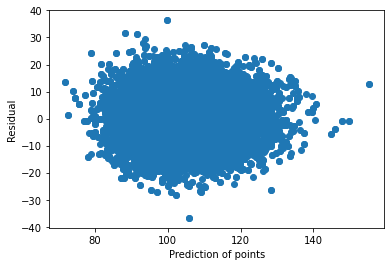

In [279]:
import matplotlib.pyplot as plt
fig = plt.scatter(fit.predict(), fit.resid)
fig.axes.set_ylabel("Residual")
fig.axes.set_xlabel("Prediction of points")

plt.savefig("initial_data.png")

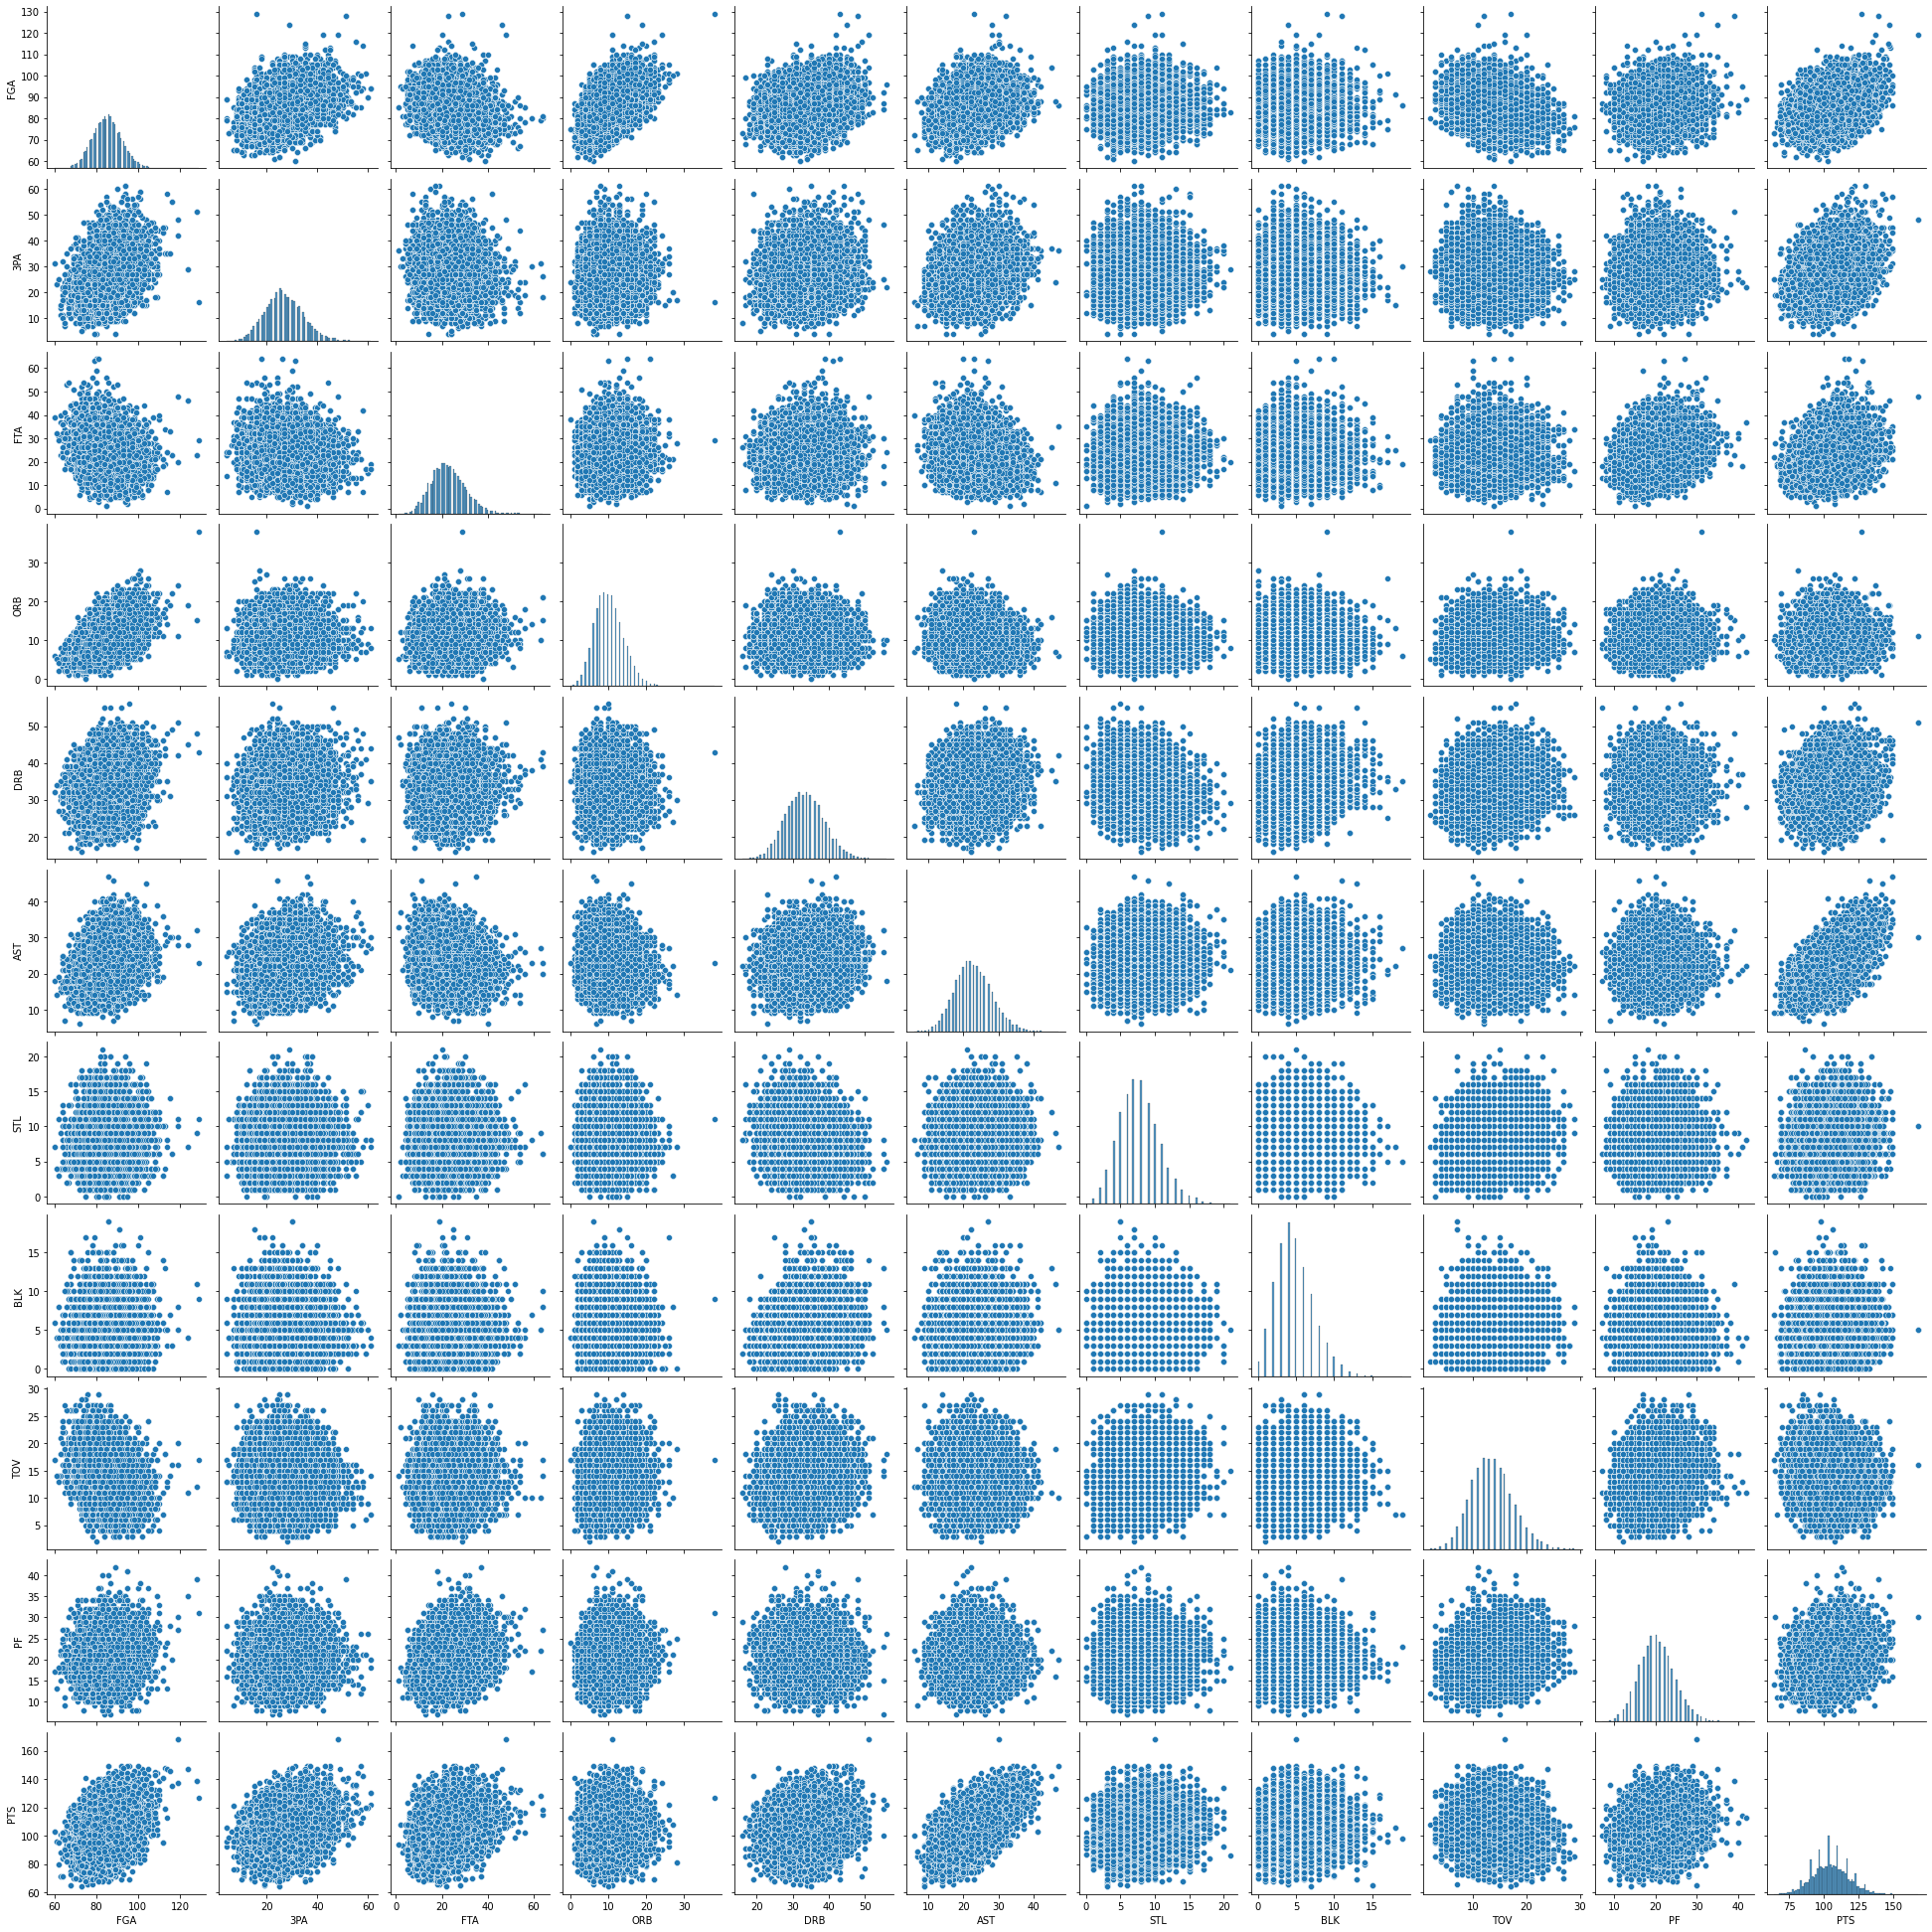

In [269]:
sns.pairplot(full_games.drop(columns=["Team","Date","3P%","FT%","FG%","MP","FG","3P","FT","TRB","Win"]));
plt.savefig("initial_pairplot.png")

/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


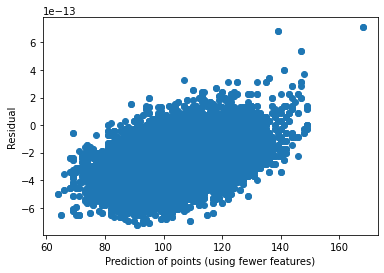

In [270]:
y = full_games["PTS"]
x = full_games.drop(columns=["Team","Date","Win","3P%","FT%","FG%","MP","FG","3P","FT","TRB","BLK","STL","TOV","AST"])
x = sm.add_constant(x)

model=sm.OLS(y,x, data=full_games)

fit = model.fit()
fit.predict()

import matplotlib.pyplot as plt
fig = plt.scatter(fit.predict(), fit.resid)
fig.axes.set_ylabel("Residual")
fig.axes.set_xlabel("Prediction of points (using fewer features)")

plt.savefig("second_data.png")

In [272]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.604e+30
Date:                Sun, 13 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:16:47   Log-Likelihood:             6.3169e+05
No. Observations:               23047   AIC:                        -1.263e+06
Df Residuals:                   23039   BIC:                        -1.263e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.232e-12   3.04e-14     73.310      0.0

In [371]:
y = full_games["PTS"]
x = full_games.drop(columns=["Team","Date","Win","3P%","FT%","FG%","MP","FG","3P","FT","TRB","PTS"])

In [372]:
X, X_test, y, y_test = train_test_split(x, y, test_size=.2,random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.25, random_state=12)

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [320]:
lm = LinearRegression()
lm_fit = lm.fit(X_train,y_train)
lm_cv = cross_val_score (lm, X_train, y_train, cv=kf,scoring="r2")
print(lm_cv)

[0.57585351 0.54949939 0.57083562 0.58140343 0.57164227]


In [321]:
y2 = full_games["PTS"]
x2 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS"])

In [323]:
X2, X2_test, y2, y2_test = train_test_split(x2, y2, test_size=.2,random_state=12)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2,y2,test_size=.25, random_state=12)

In [324]:
lm2 = LinearRegression()
lm2_fit = lm2.fit(X2_train,y2_train)
lm2_cv = cross_val_score (lm2, X2_train, y2_train, cv=kf,scoring="r2")
print(lm2_cv)

[0.73111134 0.72472702 0.73042056 0.74311153 0.73284819]


In [329]:
lm2_cv_val = cross_val_score(lm2,X2_val,y2_val,cv=kf,scoring="r2")
print(lm2_cv_val)

[0.7292473  0.72661335 0.7267446  0.74464529 0.76403693]


/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


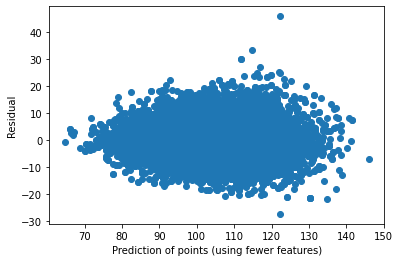

In [568]:
X2_stats = sm.add_constant(X2_train)
model2=sm.OLS(y2_train,X2_stats, data=full_games)

fit2 = model2.fit()
fit2.predict()

import matplotlib.pyplot as plt
fig2 = plt.scatter(fit2.predict(), fit2.resid)
fig2.axes.set_ylabel("Residual")
fig2.axes.set_xlabel("Prediction of points (using fewer features)")

plt.savefig("lm2.png")

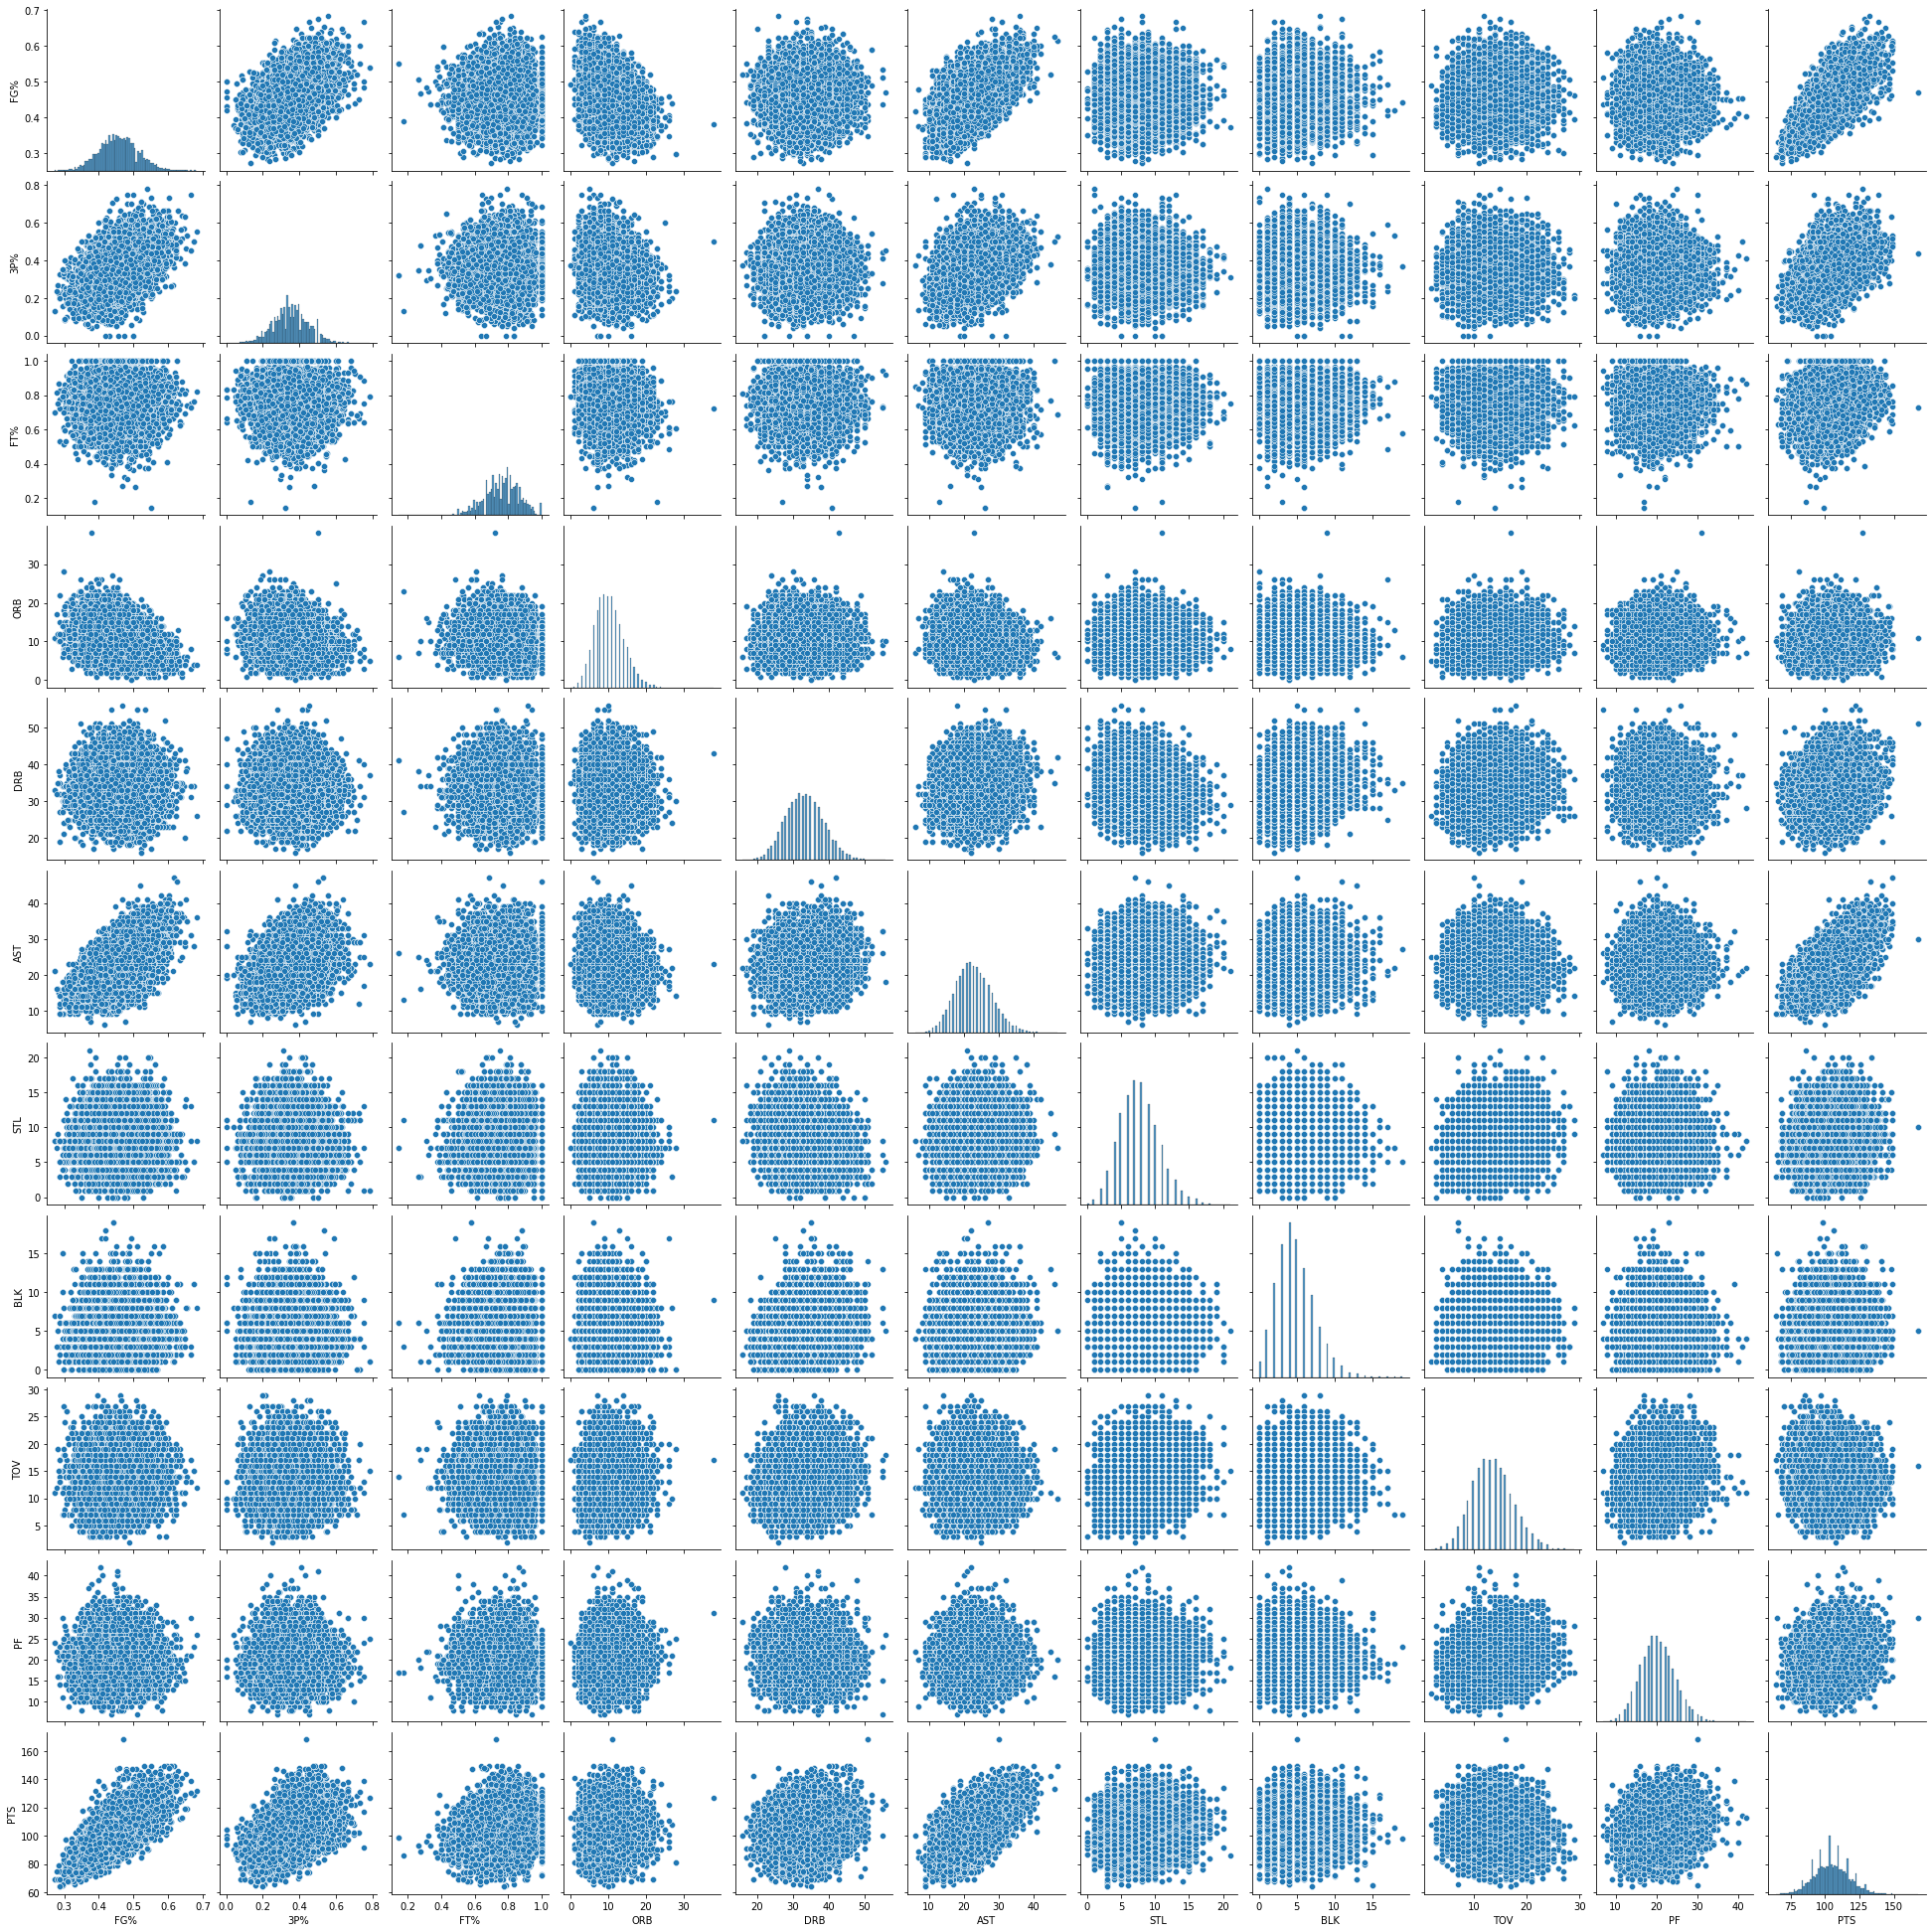

In [415]:
sns.pairplot(full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB"]));
plt.savefig("lm2_pairplot.png")

In [325]:
y3 = full_games["PTS"]
x3 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","PF"])

In [326]:
X3, X3_test, y3, y3_test = train_test_split(x3, y3, test_size=.2,random_state=12)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3,y3,test_size=.25, random_state=12)

In [327]:
lm3 = LinearRegression()
lm3_fit = lm3.fit(X3_train,y3_train)
lm3_cv = cross_val_score (lm3, X3_train, y3_train, cv=kf,scoring="r2")
print(lm3_cv)

[0.69738421 0.69748908 0.70567501 0.71373828 0.7061883 ]


In [330]:
lm3_cv_val = cross_val_score(lm3,X3_val,y3_val,cv=kf,scoring="r2")
print(lm3_cv_val)

[0.71542775 0.69173292 0.70175502 0.72044636 0.73756221]


In [514]:
y4 = full_games["PTS"]
x4 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","FG%","FT%"])

In [515]:
X4, X4_test, y4, y4_test = train_test_split(x4, y4, test_size=.2,random_state=12)
X4_train, X4_val, y4_train, y4_val = train_test_split(X4,y4,test_size=.25, random_state=12)

In [516]:
lm4 = LinearRegression()
lm4_fit = lm4.fit(X4_train,y4_train)
lm4_cv = cross_val_score (lm4, X4_train, y4_train, cv=kf,scoring="r2")
print(lm4_cv)
#3PT% only

[0.50472907 0.48091591 0.49185514 0.52232194 0.5001573 ]


In [517]:
lm4_cv_val = cross_val_score(lm4,X4_val,y4_val, cv=kf,scoring="r2")
print(lm4_cv_val)

[0.51108564 0.48557918 0.49256628 0.49028176 0.53409957]


In [518]:
y5 = full_games["PTS"]
x5 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","FG%","3P%"])

In [519]:
X5, X5_test, y5, y5_test = train_test_split(x5, y5, test_size=.2,random_state=12)
X5_train, X5_val, y5_train, y5_val = train_test_split(X5,y5,test_size=.25, random_state=12)

In [520]:
lm5 = LinearRegression()
lm5_fit = lm5.fit(X5_train,y5_train)
lm5_cv = cross_val_score (lm5, X5_train, y5_train, cv=kf,scoring="r2")
print(lm5_cv)
#FT% only

[0.43954531 0.41165819 0.42849655 0.44872987 0.43780724]


In [521]:
y6 = full_games["PTS"]
x6 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","ORB","FT%","3P%"])

In [522]:
X6, X6_test, y6, y6_test = train_test_split(x6, y6, test_size=.2,random_state=12)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6,y6,test_size=.25, random_state=12)

In [523]:
lm6 = LinearRegression()
lm6_fit = lm6.fit(X6_train,y6_train)
lm6_cv = cross_val_score (lm6, X6_train, y6_train, cv=kf,scoring="r2")
print(lm6_cv)
#FG% only

[0.63235558 0.62062698 0.6192849  0.63844782 0.63683576]


In [540]:
#offensive only
y7 = full_games["PTS"]
x7 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","ORB","FT%","BLK","STL","DRB","PF"])


In [541]:
X7, X7_test, y7, y7_test = train_test_split(x7, y7, test_size=.2,random_state=12)
X7_train, X7_val, y7_train, y7_val = train_test_split(X7,y7,test_size=.25, random_state=12)

In [542]:
lm7 = LinearRegression()
lm7_fit = lm7.fit(X7_train,y7_train)
lm7_cv = cross_val_score (lm7, X7_train, y7_train, cv=kf,scoring="r2")
print(lm7_cv)

[0.58918247 0.58938678 0.58341283 0.59331473 0.59420955]


In [543]:
#defensive only
y8 = full_games["PTS"]
x8 = full_games.drop(columns=["Team","Date","Win","3PA","FTA","FGA","MP","FG","3P","FT","TRB","PTS","ORB","FG%","3P%","AST","TOV"])


In [544]:
X8, X8_test, y8, y8_test = train_test_split(x8, y8, test_size=.2,random_state=12)
X8_train, X8_val, y8_train, y8_val = train_test_split(X8,y8,test_size=.25, random_state=12)

In [545]:
lm8 = LinearRegression()
lm8_fit = lm8.fit(X8_train,y8_train)
lm8_cv = cross_val_score (lm8, X8_train, y8_train, cv=kf,scoring="r2")
print(lm8_cv)

[0.0866322  0.07141311 0.08663405 0.10321716 0.08372127]


In [334]:
y_actual_train = y2_train
y_predicted_train = lm2.predict(X2_train)
y_predicted_train.shape

(13827,)

In [335]:
from math import sqrt
sqrt(mean_squared_error(y_actual_train, y_predicted_train))

6.432144752297009

In [373]:
lm.predict(X_train)

array([101.69901,  90.25612, 112.4858 , ..., 125.00544, 105.73537,
       104.06148], dtype=float32)

In [309]:
lm.score(X_train,y_train)

0.5712722492968665

In [315]:
lm_predictions = lm.predict(X_train)
print(mean_squared_error(y_train,lm_predictions))
print(mean_absolute_error(y_train,lm_predictions))
print(lm.intercept_)
print(lm.coef_)

66.45001928163505
6.518291400022806
10.211069210806144
[ 0.          0.54407109  0.17700281  0.72518722 -0.46451086  0.01154123
  1.32281934 -0.02792272 -0.01705204 -0.07811806  0.11546314]


In [336]:
lm2.predict(X2_train)

array([ 99.97294 ,  86.74718 , 114.32737 , ..., 112.516   , 107.988846,
       114.39774 ], dtype=float32)

In [364]:
lm2.score(X2_train,y2_train)

0.7330695601182653

In [338]:
lm2_predictions = lm2.predict(X2_train)
print(mean_squared_error(y2_train,lm2_predictions))
print(mean_absolute_error(y2_train,lm2_predictions))
print(lm2.intercept_)
print(lm2.coef_)

41.372486
5.082018
-18.767662
[ 1.4188762e+02  1.9778049e+01  2.0609470e+01  9.0112591e-01
  3.7209773e-01  4.2810059e-01  4.7568676e-01 -7.0120275e-02
 -6.5348327e-01  4.9529338e-01]


/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3067015982.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr2, mask=np.zeros_like(corr2, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


<AxesSubplot:>

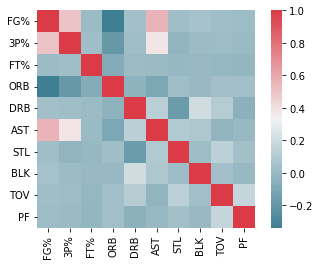

In [533]:
corr2 = X2_train.corr()
sns.heatmap(corr2, mask=np.zeros_like(corr2, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

In [570]:
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     3794.
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:49:00   Log-Likelihood:                -45356.
No. Observations:               13827   AIC:                         9.073e+04
Df Residuals:                   13816   BIC:                         9.082e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.7676      0.848    -22.129      0.0

In [612]:
#lm2 most successful - modify
y2a = full_games["PTS"]
x2a = full_games.drop(columns=["Team","Date","Win","MP","FG","3P","FT","TRB","PTS","DRB","BLK"])

In [613]:
X2a, X2a_test, y2a, y2a_test = train_test_split(x2a, y2a, test_size=.2,random_state=12)
X2a_train, X2a_val, y2a_train, y2a_val = train_test_split(X2a,y2a,test_size=.25, random_state=12)

In [614]:
lm2a = LinearRegression()
lm2a_fit = lm2a.fit(X2a_train,y2a_train)
lm2a_cv = cross_val_score (lm2a, X2a_train, y2a_train, cv=kf,scoring="r2")
print(lm2a_cv)
print(lm2_cv)

[0.98716827 0.9874034  0.98799955 0.98856723 0.9870715 ]
[0.73111134 0.72472702 0.73042056 0.74311153 0.73284819]


In [615]:
#refit lm2
lm2a = LinearRegression()
lm2a_fit = lm2a.fit(X2a, y2a)
lm2a_cv = cross_val_score (lm2a,X2a,y2a,cv=kf,scoring="r2")
print(lm2a_cv)

[0.9889127  0.98724656 0.9876635  0.98768429 0.98856751]


In [611]:
#score on test
lm2a.score(X2a_test,y2a_test)

0.9873761485319024

/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


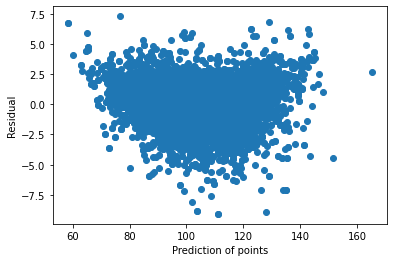

In [642]:
X2a_stats = sm.add_constant(X2a_train)
model3=sm.OLS(y2a_train,X2a_stats, data=full_games)

fit3 = model3.fit()
fit3.predict()

fig3 = plt.scatter(fit3.predict(), fit3.resid)
fig3.axes.set_ylabel("Residual")
fig3.axes.set_xlabel("Prediction of points")

plt.savefig("lm3.png")

/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3216529897.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr3, mask=np.zeros_like(corr3, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


<AxesSubplot:>

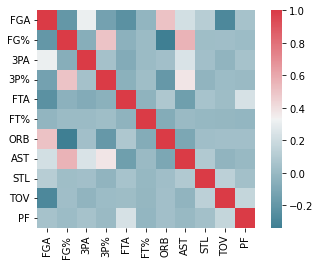

In [617]:
corr3 = X2a_train.corr()
sns.heatmap(corr3, mask=np.zeros_like(corr3, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


In [618]:
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.008e+05
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:05:35   Log-Likelihood:                -24083.
No. Observations:               13827   AIC:                         4.819e+04
Df Residuals:                   13815   BIC:                         4.828e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -101.0021      0.267   -378.621      0.0

In [628]:
#lm2 most successful - modify
# add in 2P FG only (FG incluedes 3P)
y2b = full_games["PTS"]
x2b = full_games
x2b["2PA"] = x2b["FGA"] - x2b["3PA"]
x2b["2P"] = x2b["FG"] - x2b["3P"]
x2b["2P%"] = x2b["2P"] / x2b["2PA"]
x2b = x2b.drop(columns=["Team","Date","Win","MP","FG","3P","2P","FT","TRB","PTS","DRB","BLK","ORB","STL","TOV","PF"])


In [629]:
X2b, X2b_test, y2b, y2b_test = train_test_split(x2b, y2b, test_size=.2,random_state=12)
X2b_train, X2b_val, y2b_train, y2b_val = train_test_split(X2b,y2b,test_size=.25, random_state=12)

In [630]:
lm2b = LinearRegression()
lm2b_fit = lm2b.fit(X2b_train,y2b_train)
lm2b_cv = cross_val_score (lm2b, X2b_train, y2b_train, cv=kf,scoring="r2")

print(lm2b_cv)
print(lm2a_cv)
print(lm2_cv)

[0.98899158 0.98900458 0.98965687 0.99007466 0.98916823]
[0.9889127  0.98724656 0.9876635  0.98768429 0.98856751]
[0.73111134 0.72472702 0.73042056 0.74311153 0.73284819]


In [925]:
lm2b = LinearRegression()
lm2b_fit = lm2b.fit(X2b_train,y2b_train)
lm2b_cvb = cross_val_score (lm2b, X2b_train, y2b_train, cv=kf,scoring="neg_root_mean_squared_error")
print(lm2b_cvb)

[-1.30344033 -1.26371527 -1.26180971 -1.27076674 -1.31043863]


/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


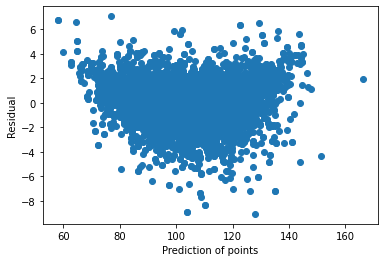

In [641]:
X2b_stats = sm.add_constant(X2b_train)
model4=sm.OLS(y2b_train,X2b_stats, data=full_games)

fit4 = model4.fit()
fit4.predict()

fig4 = plt.scatter(fit4.predict(), fit4.resid)
fig4.axes.set_ylabel("Residual")
fig4.axes.set_xlabel("Prediction of points")

plt.savefig("lm4.png")

In [632]:
print(fit4.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.434e+05
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:26:22   Log-Likelihood:                -23048.
No. Observations:               13827   AIC:                         4.612e+04
Df Residuals:                   13817   BIC:                         4.619e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -101.1991      0.223   -453.418      0.0

/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3168759150.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr4, mask=np.zeros_like(corr4, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


<AxesSubplot:>

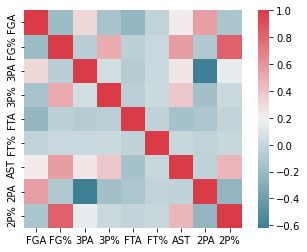

In [633]:
corr4 = X2b_train.corr()
sns.heatmap(corr4, mask=np.zeros_like(corr4, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


In [681]:
#lm2 most successful - modify
#remove all FG features - now represented by 3P and 2P
y2c = full_games["PTS"]
x2c = full_games
x2c["2PA"] = x2c["FGA"] - x2c["3PA"]
x2c["2P"] = x2c["FG"] - x2c["3P"]
x2c["2P%"] = x2c["2P"] / x2c["2PA"]
x2c = x2c.drop(columns=["Team","Date","Win","MP","FG","3P","2P","FT","TRB","PTS","DRB","BLK","ORB","STL","TOV","PF","FGA","FG%"])


In [682]:
X2c, X2c_test, y2c, y2c_test = train_test_split(x2c, y2c, test_size=.2,random_state=12)
X2c_train, X2c_val, y2c_train, y2c_val = train_test_split(X2c,y2c,test_size=.25, random_state=12)

In [934]:
## FINAL MODEL - R2
lm2c = LinearRegression()
lm2c_fit = lm2c.fit(X2c_train,y2c_train)
lm2c_cv = cross_val_score (lm2c, X2c_train, y2c_train, cv=kf,scoring="r2")

print(lm2c_cv)
print(lm2b_cv)
print(lm2a_cv)
print(lm2_cv)
print("mean: "+str(lm2c_cv.mean()))
print("std: "+str(lm2c_cv.std()))

[0.95880653 0.9559033  0.95856977 0.96235671 0.95391775]
[0.98899158 0.98900458 0.98965687 0.99007466 0.98916823]
[0.9889127  0.98724656 0.9876635  0.98768429 0.98856751]
[0.73111134 0.72472702 0.73042056 0.74311153 0.73284819]
mean: 0.9579108115689661
std: 0.0028627682696759434


In [935]:
## FINAL MODEL - RMSE
lm2c = LinearRegression()
lm2c_fit = lm2c.fit(X2c_train,y2c_train)
lm2c_cvb = cross_val_score (lm2c, X2c_train, y2c_train, cv=kf,scoring="neg_root_mean_squared_error")
print("mean: "+str(lm2c_cvb.mean()))
print("std: "+str(lm2c_cvb.std()))

mean: -2.5510446071624755
std: 0.07852773316407954


In [936]:
## Refit final model using train + validate sets
lm2c_fit = lm2c.fit(X2c,y2c)
lm2c_cv_r2_refit = cross_val_score (lm2c, X2c, y2c, cv=kf,scoring="r2")
lm2c_cv_rmse_refit = cross_val_score (lm2c, X2c, y2c, cv=kf,scoring="neg_root_mean_squared_error")

print("mean r2: "+str(lm2c_cv_r2_refit.mean()))
print("std: "+str(lm2c_cv_r2_refit.std()))
print("mean rmse: "+str(lm2c_cv_rmse_refit.mean()))
print("std: "+str(lm2c_cv_rmse_refit.std()))

mean r2: 0.9588920303534378
std: 0.0012960824368525037
mean rmse: -2.5301886081695555
std: 0.040818058832055706


In [937]:
lm2c_cv_r2 = cross_val_score (lm2c, X2c_test, y2c_test, cv=kf,scoring="r2")
lm2c_cv_rmse = cross_val_score (lm2c, X2c_test, y2c_test, cv=kf,scoring="neg_root_mean_squared_error")
print("mean r2: "+ str(lm2c_cv_r2.mean()))
print("std: "+str(lm2c_cv_r2.std()))
print("mean r2: "+str(lm2c_cv_rmse.mean()))
print("std: "+str(lm2c_cv_rmse.std()))

mean r2: 0.9553555614694945
std: 0.0025512574428398064
mean r2: -2.6242979049682615
std: 0.0784175740440613


/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


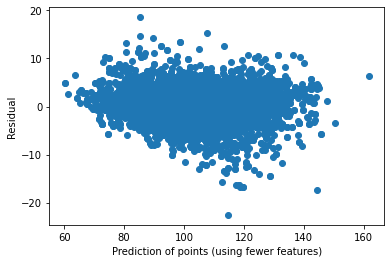

In [684]:
X2c_stats = sm.add_constant(X2c_train)
model5=sm.OLS(y2c_train,X2c_stats, data=full_games)

fit5 = model5.fit()
fit5.predict()

fig5 = plt.scatter(fit5.predict(), fit5.resid)
fig5.axes.set_ylabel("Residual")
fig5.axes.set_xlabel("Prediction of points (using fewer features)")

plt.savefig("lm5.png")

/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3891145642.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr5, mask=np.zeros_like(corr5, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


<AxesSubplot:>

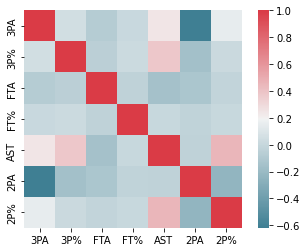

In [695]:
corr5 = X2c_train.corr()
sns.heatmap(corr5, mask=np.zeros_like(corr5, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


In [685]:
print(fit5.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 4.511e+04
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:16:12   Log-Likelihood:                -32558.
No. Observations:               13827   AIC:                         6.513e+04
Df Residuals:                   13819   BIC:                         6.519e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -93.5102      0.437   -214.054      0.0

In [896]:
#new model with only secondary features
y = full_games["PTS"]
x_alt = full_games.drop(columns=["Team","Date","Win","MP","FG","FGA","FG%","3P","3PA","3P%",
                                 "FT","FTA","FT%","2P","2PA","2P%","TRB","PTS","BLK"])

In [897]:
X_alt, X_alt_test, y_alt, y_alt_test = train_test_split(x_alt, y, test_size=.2,random_state=12)
X_alt_train, X_alt_val, y_alt_train, y_alt_val = train_test_split(X_alt,y_alt,test_size=.25, random_state=12)

In [898]:
lm_alt = LinearRegression()
lm_alt_fit = lm_alt.fit(X_alt_train,y_alt_train)
lm_alt_cv = cross_val_score (lm_alt, X_alt_train, y_alt_train, cv=kf,scoring="r2")
print(lm_alt_cv)

[0.41312915 0.3854777  0.39665916 0.42045845 0.41198917]


In [927]:
lm_alt = LinearRegression()
lm_alt_fit = lm_alt.fit(X_alt_train,y_alt_train)
lm_alt_cvb = cross_val_score (lm_alt, X_alt_train, y_alt_train, cv=kf,scoring="neg_root_mean_squared_error")
print(lm_alt_cvb)

[-9.51699596 -9.4473951  -9.63716573 -9.71036044 -9.65516241]


In [938]:
lm_alt = LinearRegression()
lm_alt_refit = lm_alt.fit(X_alt,y_alt)
lm_alt_refit_cv_r2 = cross_val_score (lm_alt, X_alt, y_alt, cv=kf,scoring="r2")
lm_alt_refit_cv_rmse = cross_val_score (lm_alt, X_alt, y_alt, cv=kf,scoring="neg_root_mean_squared_error")
lm_alt_cv_r2 = cross_val_score (lm_alt, X_alt_test, y_alt_test, cv=kf,scoring="r2")
lm_alt_cv_rmse = cross_val_score (lm_alt, X_alt_test, y_alt_test, cv=kf,scoring="neg_root_mean_squared_error")

print("mean r2: "+ str(lm_alt_refit_cv_r2.mean()))
print("std: "+str(lm_alt_refit_cv_r2.std()))
print("mean rmse: "+str(lm_alt_refit_cv_rmse.mean()))
print("std: "+str(lm_alt_refit_cv_rmse.std()))

print("mean r2: "+ str(lm_alt_cv_r2.mean()))
print("std: "+str(lm_alt_cv_r2.std()))
print("mean rmse: "+str(lm_alt_cv_rmse.mean()))
print("std: "+str(lm_alt_cv_rmse.std()))

mean r2: 0.40687322503917134
std: 0.013438156092094342
mean rmse: -9.611384769655851
std: 0.10251846371072472
mean r2: 0.4119940769015499
std: 0.023319724047904045
mean rmse: -9.525884353654718
std: 0.19547544916498452


/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


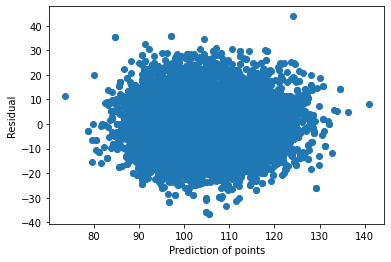

In [899]:
X_alt_stats = sm.add_constant(X_alt_train)
model_alt=sm.OLS(y_alt_train,X_alt_stats, data=full_games)

fit_alt = model_alt.fit()
fit_alt.predict()

fit_alt = plt.scatter(fit_alt.predict(), fit_alt.resid)
fit_alt.axes.set_ylabel("Residual")
fit_alt.axes.set_xlabel("Prediction of points")

plt.savefig("alt.png")

/var/folders/6l/6tcwml6d7hqb9tfsn7kf5z6r0000gn/T/ipykernel_76807/3575839489.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr_alt, mask=np.zeros_like(corr_alt, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


<AxesSubplot:>

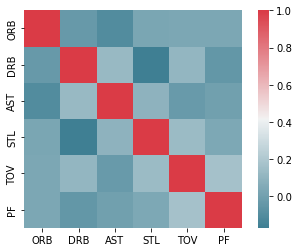

In [900]:
corr_alt = X_alt_train.corr()
sns.heatmap(corr_alt, mask=np.zeros_like(corr_alt, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)


In [901]:
print(model_alt.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     1582.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:14:05   Log-Likelihood:                -50873.
No. Observations:               13827   AIC:                         1.018e+05
Df Residuals:                   13820   BIC:                         1.018e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.2054      0.819     68.651      0.0

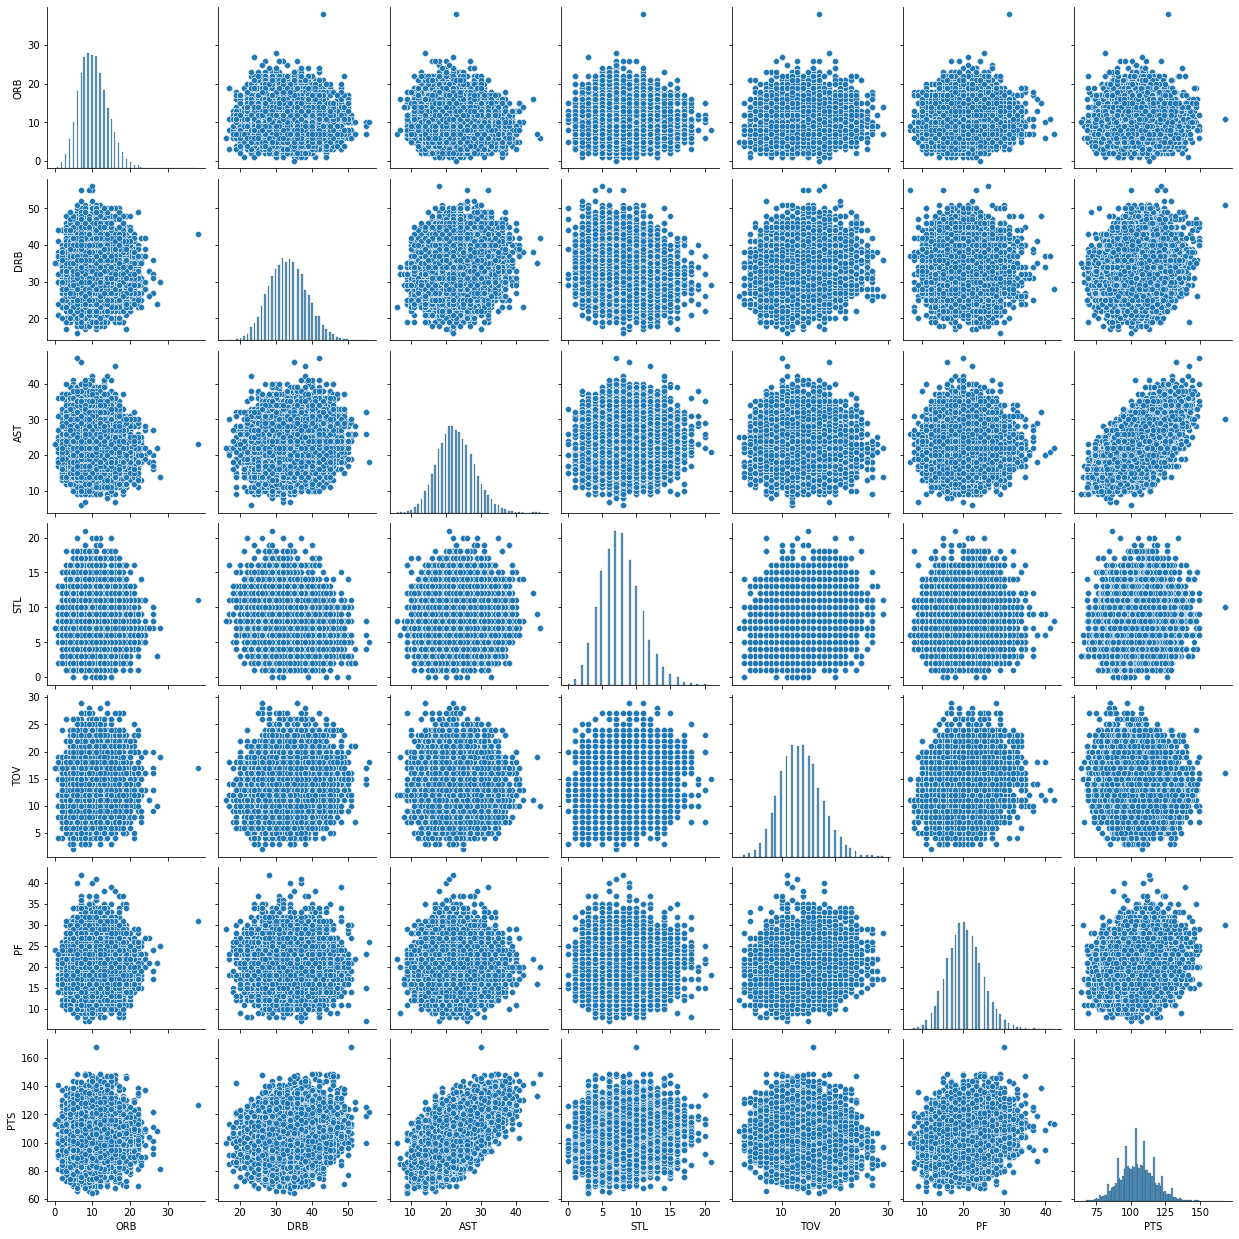

In [883]:
sns.pairplot(full_games.drop(columns=["Team","Date","Win","MP","FG","FGA","FG%","3P","3PA","3P%",
                                 "FT","FTA","FT%","2P","2PA","2P%","TRB","BLK"]));
plt.savefig("alt_pairplot.png")

In [884]:
#scaling data on best model
std = StandardScaler()
std.fit(X_alt_train.values)

StandardScaler()

In [885]:
X_alt_tr = std.transform(X_alt_train.values)
X_alt_v = std.transform(X_alt_val.values)
X_alt_te = std.transform(X_alt_test.values)

In [886]:
ridge = Ridge(alpha=2)
ridge.fit(X_alt_train,y_alt_train)


Ridge(alpha=2)

In [887]:

alphas = 10**np.linspace(-2,2,200)
ridge_cv = RidgeCV(alphas=alphas, cv=kf)
ridge_cv.fit(X_alt_tr,y_alt_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=KFold(n_splits=5, random_state=42, shuffle=True))

In [888]:
ridge.score(X_alt_train,y_alt_train)

0.4071286457792932

In [889]:

list(zip(X_alt_train.columns, ridge_cv.coef_))

[('ORB', 0.71890056),
 ('DRB', 1.4417793),
 ('AST', 7.0823817),
 ('STL', 0.98525155),
 ('TOV', -1.9949814),
 ('PF', 2.22482)]

In [890]:
ridge_cv_pred = ridge_cv.predict(X_alt_val)

/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


[]

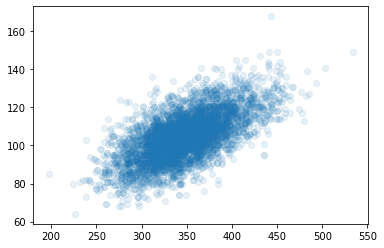

In [891]:
plt.scatter(ridge_cv_pred, y_alt_val, alpha=.1)
plt.plot()

[]

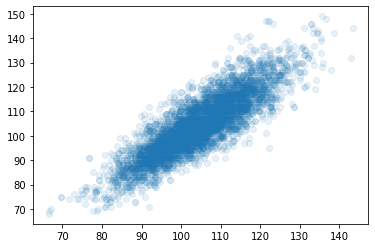

In [581]:
lm2_pred = lm2.predict(X2_test)
plt.scatter(lm2_pred, y2_test, alpha=.1)
plt.plot()

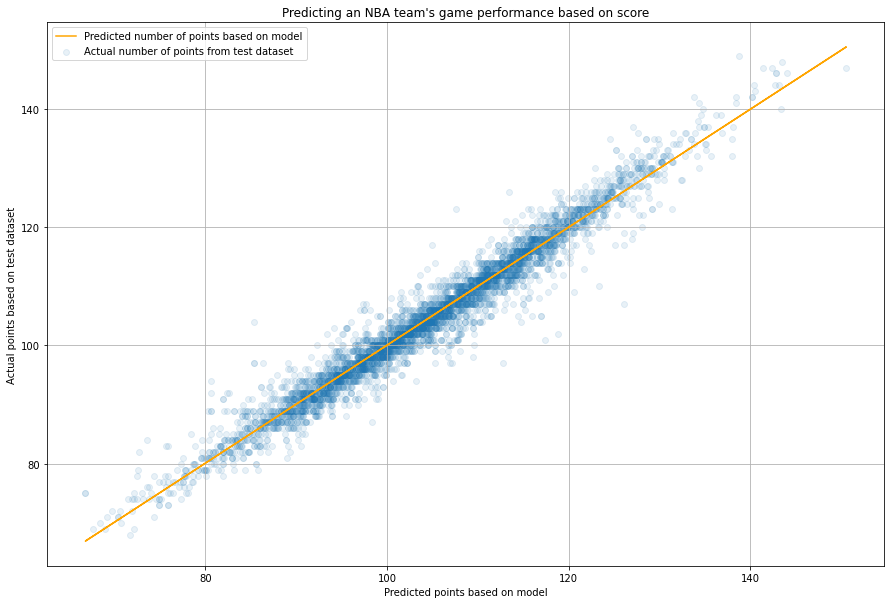

In [931]:
lm2c_pred = lm2c.predict(X2c_test)
plt.scatter(lm2c_pred, y2c_test, alpha=.1,label="Actual number of points from test dataset")
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(lm2c_pred, y2c_test, 1)

#add linear regression line to scatterplot 
plt.plot(lm2c_pred, m*lm2c_pred+b,color = "orange",label="Predicted number of points based on model")
plt.title("Predicting an NBA team's game performance based on score")
plt.xlabel("Predicted points based on model")
plt.ylabel("Actual points based on test dataset")
plt.legend()
plt.gcf().set_size_inches((15, 10))
plt.grid()
plt.plot()
plt.savefig("lm2c_predict_test.png")

In [909]:
#convert float32 to float64 to avoid error
x_alt["ORB"]=np.asarray(x_alt["ORB"],dtype = np.float64) 
x_alt["DRB"]=np.asarray(x_alt["DRB"],dtype = np.float64)
x_alt["AST"]=np.asarray(x_alt["AST"],dtype = np.float64)
x_alt["STL"]=np.asarray(x_alt["STL"],dtype = np.float64)
x_alt["TOV"]=np.asarray(x_alt["TOV"],dtype = np.float64)
x_alt["PF"]=np.asarray(x_alt["PF"],dtype = np.float64)

std = StandardScaler()
std.fit(X_alt_train.values)

X_alt_tr = std.transform(X_alt_train.values)
X_alt_v = std.transform(X_alt_val.values)
X_alt_te = std.transform(X_alt_test.values)

In [910]:
X_alt, X_alt_test, y_alt, y_alt_test = train_test_split(x_alt, y, test_size=.2,random_state=12)
X_alt_train, X_alt_val, y_alt_train, y_alt_val = train_test_split(X_alt,y_alt,test_size=.25, random_state=12)

In [911]:
lasso = Lasso(alpha=10000)
lasso.fit(X_alt_train,y_alt_train)
lasso.score(X_alt_train,y_alt_train)

-1.6393042479023734e-09

In [912]:
alphas_l = 10**np.linspace(-2,2,200)
lasso_cv = LassoCV(alphas=alphas_l, cv=kf)
lasso_cv.fit(X_alt_tr,y_alt_train)
lasso_cv.score(X_alt_tr,y_alt_train)

0.4071239160949196

/Users/sanciayang/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


[]

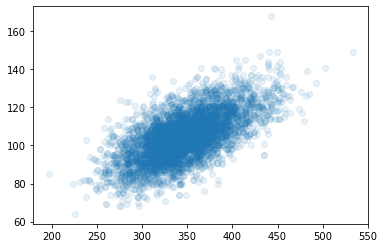

In [914]:
lasso_cv_pred = lasso_cv.predict(X_alt_val)
plt.scatter(lasso_cv_pred, y_alt_val, alpha=.1)
plt.plot()

In [915]:
lasso_cv.alpha_

0.01

In [916]:
ridge_cv.alpha_

20.72921779595372

In [917]:
list(zip(X_alt_train.columns, lasso_cv.coef_))

[('ORB', 0.7100923007699755),
 ('DRB', 1.4295986711734763),
 ('AST', 7.085025334507627),
 ('STL', 0.9734229546812795),
 ('TOV', -1.9832591322699529),
 ('PF', 2.216479090175192)]

In [918]:
elastic = ElasticNet(alpha=1, l1_ratio = .5)
elastic.fit(X_alt_tr,y_alt_train)
elastic.score(X_alt_tr,y_alt_train)

0.3368732613843143

In [919]:
alphas_e = [.0001, .01, .1, .3, .5, .7, 1]
l1_rat = [.1, .5, .7, .9, .95, .99, 1]
elastic_cv = ElasticNetCV( alphas = alphas_e, l1_ratio=l1_rat,cv=kf)
elastic_cv.fit(X_alt_train,y_alt_train)
elastic_cv.score(X_alt_train,y_alt_train)

0.4071285595284885